## Chaper 8

### building interaction datasets

Before we move on to use ML approaches to recommend items, we need to build a couple of datasets adequate for our purposes. 

### 1. Interaction dataframe with a measure of interest 

we will first create a dataframe with a measure of the interest on a given coupon by a given user. Such measure of interest will be of course based on the number of times they have purchased or visited that coupon. 

Let's go

In [44]:
import numpy as np
import pandas as pd
import os
import argparse
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from scipy.sparse import lil_matrix, csr_matrix, save_npz

inp_dir = "../datasets/Ponpare/data_processed"
out_dir = "../datasets/Ponpare/data_processed"

As usual

In [45]:
# Interactions
df_purchases_train = pd.read_pickle(os.path.join(inp_dir, 'train', 'df_purchases_train.p'))
df_visits_train = pd.read_pickle(os.path.join(inp_dir, 'train', 'df_visits_train.p'))
df_visits_train.rename(index=str, columns={'view_coupon_id_hash': 'coupon_id_hash'}, inplace=True)

# train users and coupons
df_coupons_train_feat = pd.read_pickle(os.path.join(inp_dir, 'train', 'df_coupons_train_feat.p'))
df_user_train_feat = pd.read_pickle(os.path.join(inp_dir, 'train', 'df_user_train_feat.p'))
train_users = df_user_train_feat.user_id_hash.unique()
train_coupons = df_coupons_train_feat.coupon_id_hash.unique()

# subset activities according to the users and coupons in training
df_vtr = df_visits_train[df_visits_train.user_id_hash.isin(train_users) &
    df_visits_train.coupon_id_hash.isin(train_coupons)]
df_ptr = df_purchases_train[df_purchases_train.user_id_hash.isin(train_users) &
    df_purchases_train.coupon_id_hash.isin(train_coupons)]

Remember from previous notebooks that we lose one customer (22624->22623) than viewed on coupon that is not among the training coupons and bought another coupon but not during the training period.

For purchases it will be easy, "interest" will be 1.

In [46]:
# for purchases interest will be 1
df_interest_ptr = (df_ptr
    .groupby(['user_id_hash','coupon_id_hash'])['days_to_present']
    .min()
    .reset_index())
df_interest_ptr['interest'] = 1.

df_interest_ptr.head()

,user_id_hash,coupon_id_hash,days_to_present,interest
0,0000b53e182165208887ba65c079fc21,38beeadfe3f97e640367eddae4a8c1b5,274,1.0
1,00035b86e6884589ec8d28fbf2fe7757,25a27d420caa1c46a8d3c0572d27868a,86,1.0
2,0005b1068d5f2b8f2a7c978fcfe1ca06,4a79cd05ecb2bf8672e1d955f5faa7fa,310,1.0
3,0005b1068d5f2b8f2a7c978fcfe1ca06,f0f66195d527a5a9509e139ed367b879,310,1.0
4,000cc06982785a19e2a2fdb40b1c9d59,229ff5cc21c8d26615493be7f3b42841,268,1.0


Because we have already accounted for all those interactions that ended in a purchase, let's remove them from the visits table

In [47]:
# remove from the visits table those pairs user-coupon that ended up in purchases
activity_hash_p = (df_interest_ptr['user_id_hash'] + "_" +
    df_interest_ptr['coupon_id_hash']).unique()
df_vtr['activity_hash'] = (df_vtr['user_id_hash'] + "_" +
    df_vtr['coupon_id_hash'])
df_vtr = df_vtr[~df_vtr.activity_hash.isin(activity_hash_p)]
df_vtr.drop('activity_hash', axis=1, inplace=True)

/home/ubuntu/anaconda3/envs/jrz/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


For visits, "interest" will be calculated with some funcion that will depend on number of visits. Let's first calculate the number of visits

In [48]:
# for visits will depend on number of visits
df_vtr_coupon_views = (df_vtr
    .groupby(['user_id_hash','coupon_id_hash'])
    .size()
    .reset_index())
df_vtr_coupon_views.columns = ['user_id_hash','coupon_id_hash','views_count']
df_vtr_most_recent_view = (df_vtr
    .groupby(['user_id_hash','coupon_id_hash'])['days_to_present']
    .min()
    .reset_index())
df_interest_vtr = pd.merge(df_vtr_coupon_views, df_vtr_most_recent_view,
    on=['user_id_hash','coupon_id_hash'])
df_interest_vtr['interest'] = 0.
df_interest_vtr.head()

,user_id_hash,coupon_id_hash,views_count,days_to_present,interest
0,0000b53e182165208887ba65c079fc21,0645faa156f34104e6d8910160868f9f,1,182,0.0
1,0000b53e182165208887ba65c079fc21,18097cd25ab6b7e8eb0481b0e3a3cfd8,1,267,0.0
2,0000b53e182165208887ba65c079fc21,1b581f2ed53f2f2eafbc1560db640194,1,182,0.0
3,0000b53e182165208887ba65c079fc21,1d04e76c44c231d5d05dc1634d20fe8c,2,267,0.0
4,0000b53e182165208887ba65c079fc21,2ab16b8f5aeead6d31dbdb9bd59c41db,2,267,0.0


Now we need to decide which function to use to compute interest based on visits. As has happened a few times already, there is a lot of freedom. Here I will use a sigmoid function and include the code for a "truncated linear" one. Please, feel free to experiment with any other function that you might consider adequate. 

Before moving into visualizing the function, let's have a look to the visits distribution

/home/ubuntu/anaconda3/envs/jrz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[(0, 10)]

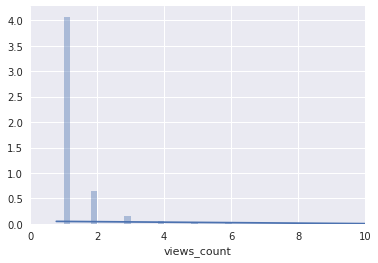

In [49]:
g = sns.distplot(df_interest_vtr.views_count, bins=5000)
g.set(xlim=(0, 10))

In [50]:
#Total number of visits:
print(df_interest_vtr.views_count.sum())
df_interest_vtr.views_count.value_counts()[:10]

1818528


1     1149969
2      180479
3       45541
4       16338
5        7073
6        3409
7        1846
8        1003
9         672
10        435
Name: views_count, dtype: int64

So $1149969/1818528 = 0.63$, 63% of the users that visited coupons visited a given coupon only once. With this information in mind, let's define our two "interest functions". 

When it comes to a sigmoid function, there are three parameters we need to define: 
1. xmid: middle point that will defines the change in trend for the S-shaped sigmoid function
2. tau: parameter that defines the slope around the middle point
3. top: parameter that defines the maximum value as x tends to infinite

For the "truncated linear", which is just a combination of two linear functions, we need to define:
1. xmid: point where the change in slope occurs
2. ylow: lower y value
3. ymid: y value where the change in slope occurs
4. ytop: upper y value

Let's visualize how these look

In [51]:
def sigmoid(x, xmid, tau, top):
    """
    Sigmoid with upper limit
    """
    return top / (1. + np.exp(-(x-xmid)/tau))


def combined_linear(x, xmid, ylow, ymid, ytop):
    """
    Truncated straight lines
    """
    m1 = (ymid-ylow)/(xmid)
    b1 = ylow

    x2 = np.max(x)
    m2 = (ytop-ymid)/(x2-xmid)
    b2 = ymid-(m2*xmid)

    x1_range = x[np.where(x<=xmid)[0]]
    x2_range = x[np.where(x>xmid)[0]]

    l1 = m1*x1_range + b1
    l2 = m2*x2_range + b2

    return np.hstack([l1,l2])


def plot_adjustment_func(x, params, xmin=None, xmax=None, func='sigmoid'):

    if not xmin: xmin = np.min(x)
    if not xmax: xmax = np.max(x)
    x = np.sort(x)

    if func == 'sigmoid':
        Z = sigmoid(x, params['xmid'], params['tau'], params['top'])
    elif func == 'linear':
        Z = combined_linear(x, params['xmid'], params['ylow'], params['ymid'], params['ytop'])

    plt.plot(x, Z, color='red', lw=0.4)
    plt.xlim((xmin, xmax))
    plt.ylabel("Interest")
    plt.show()

Let's first have a look to the modified sigmoid

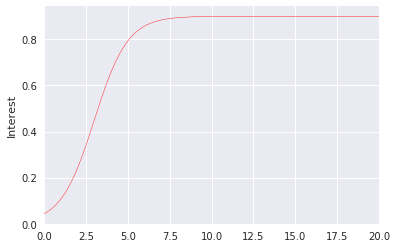

In [52]:
x = np.arange(0, 20, .01)

# This will be the actual parameters I will use
params = {'xmid': 3, 'tau': 1, 'top': 0.9} 
plot_adjustment_func(x, params)

And to the combined or "truncated" linear

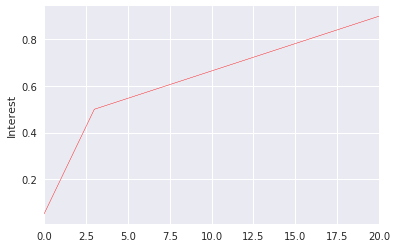

In [53]:
# Let's pick some random parameters
params = {'xmid': 3, 'ylow': 0.05, 'ymid': 0.5, 'ytop': 0.9} 
plot_adjustment_func(x, params, func='linear')

Let's concentrate on the sigmoid function since is the function that I will use throughout the notebooks. For users that only visited a coupon once, their interest in that coupon will be $\sim$0.10 (just run `sigmoid(1., 3, 1, 0.9)`). The the interest increase sharply until we get to $\sim$6 visits (Interest = 0.85). From there in advance, the Interest metric slowly increase up to 0.9, and will be never be more than that number. 

In [54]:
# interest for visits using a sigmoid
vxmid, vtau, vtop = 3, 1, 0.9
df_interest_vtr['interest'] = sigmoid(df_interest_vtr.views_count.values, vxmid, vtau, vtop)
df_interest_vtr.drop('views_count', axis=1, inplace=True)

df_interest_vtr.head()

,user_id_hash,coupon_id_hash,days_to_present,interest
0,0000b53e182165208887ba65c079fc21,0645faa156f34104e6d8910160868f9f,182,0.107283
1,0000b53e182165208887ba65c079fc21,18097cd25ab6b7e8eb0481b0e3a3cfd8,267,0.107283
2,0000b53e182165208887ba65c079fc21,1b581f2ed53f2f2eafbc1560db640194,182,0.107283
3,0000b53e182165208887ba65c079fc21,1d04e76c44c231d5d05dc1634d20fe8c,267,0.242047
4,0000b53e182165208887ba65c079fc21,2ab16b8f5aeead6d31dbdb9bd59c41db,267,0.242047


In addition, a sigmoid function can also be used to compute a "recency factor". So far we have treated all coupons as equally important, independently on when they were purchased or visisted. A good recommendation algorithm should include, or at least consider, frecency. It is likely that the likes of an individual change through time so chances are that your recommendation algorithms work better if they are biased towards more recent interactions. 

Similarly to what we did with the number counts, we can use the sigmoid function above and do:

In [55]:
# in case we want to add a factor depending on recency of purchase
df_interest = pd.concat([df_interest_ptr, df_interest_vtr],
    axis=0, ignore_index=True)
df_interest['days_to_present_inv'] = df_interest.days_to_present.max() - df_interest.days_to_present

rxmid, rtau, rtop = 150, 30, 1
df_interest['recency_factor'] = sigmoid(df_interest.days_to_present_inv.values, rxmid, rtau, rtop)
df_interest.drop(['days_to_present', 'days_to_present_inv'], axis=1, inplace=True)
df_interest = df_interest.sample(frac=1).reset_index(drop=True)

df_interest.head()

,user_id_hash,coupon_id_hash,interest,recency_factor
0,cf9805eb78cceba252d93f6050ed55e1,1d1e4ceaa8f4a0bc8e32c50ccd995fbb,0.107283,0.946174
1,bbec8235588e25699e9d8787037cc388,429035705e87670ecc3d4fcef14cc6df,0.107283,0.385406
2,20b08e8fdd08cba9c0f92112f3416d8d,48948527d6a8e075090393f3d95e31bf,0.107283,0.975873
3,f682389a94b36dabb3fc49462a3e7138,0f2ef03220f9b2a2f7bccd643c197a5a,0.242047,0.995033
4,8b969180f25aca52bb6ee01ffb71e164,c5ef0f74983c3c63ec857d584833b149,0.242047,0.574443


Let's save it to disk

In [56]:
# df_interest.to_pickle(os.path.join(out_dir,'train','df_interest.p'))

### 2. User-Item Interaction Matrix